In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

### Read org data

In [2]:
df_agg = pd.read_parquet("../../data/data_agg_v0.parquet")

price_cols = [x for x in df_agg.columns if "LAST" in x]
df_subset = df_agg[["Date"] + price_cols[:12]]
df_subset.index = df_subset["Date"]
df_subset = df_subset.drop(columns=["Date"])
print(f"Shape before dropping nulls, {df_subset.shape}")
df_subset = df_subset.dropna()
print(f"Shape after dropping nulls, {df_subset.shape}")

Shape before dropping nulls, (5152, 12)
Shape after dropping nulls, (5148, 12)


In [3]:
df_subset1 = df_subset.sort_index()

In [6]:
mask1 = df_subset1["PX_LAST_6"]>df_subset1["PX_LAST"]
mask2 = df_subset1["PX_LAST_12"]>df_subset1["PX_LAST_6"]

df_subset1["contango"] = (mask1 & mask2).astype("int")
df_subset1["contango"].mean()

0.38752913752913754

<AxesSubplot: >

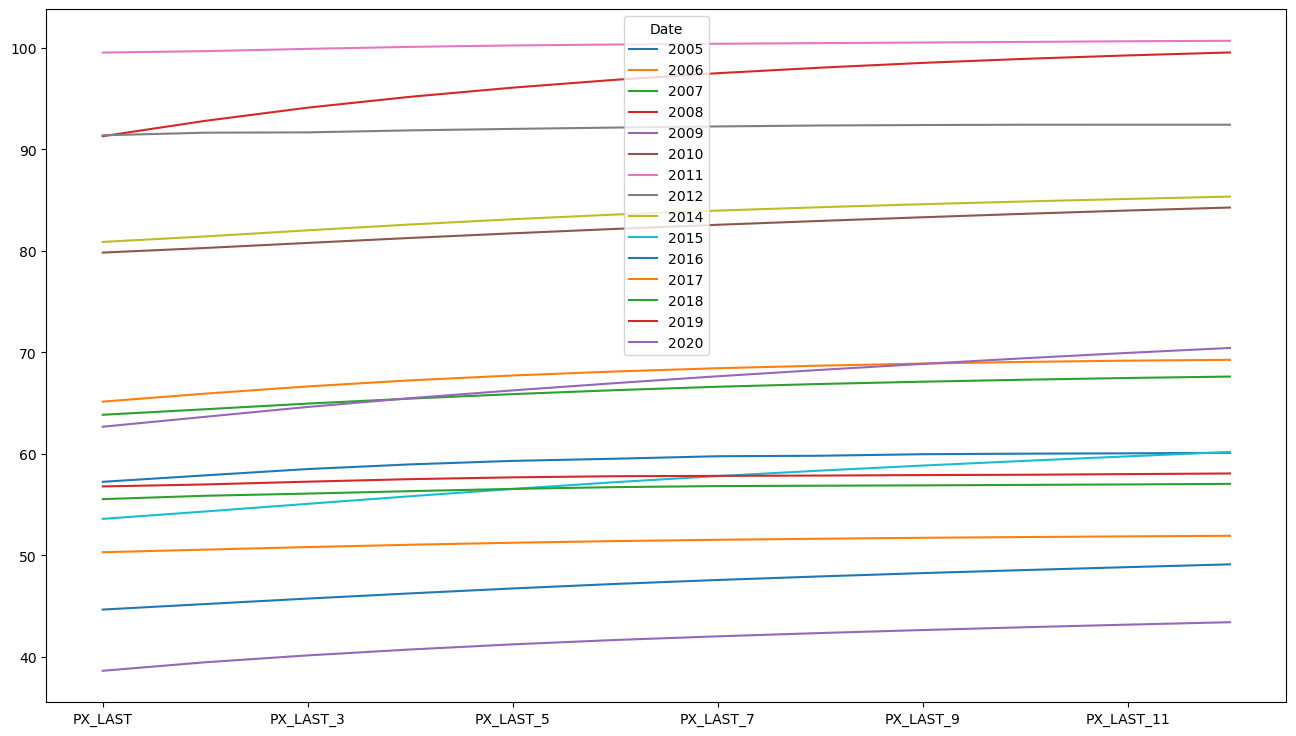

In [17]:
fig,ax = plt.subplots(figsize=(16,9))
df_subset1[df_subset1.contango>0].drop(columns="contango").groupby(lambda x: (x.year)).mean().T.plot(ax=ax)

In [24]:
pca_data = pd.read_csv("../../data/log_returns_pca.csv",index_col=0)
pca_data.shape

(1719, 6)